In [2]:
#Importing libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [3]:
# Step 1: Load Data
df = pd.read_csv("Data/train.csv")
df['Date'] = pd.to_datetime(df['Date'])

print("Dataset shape:", df.shape)

print(df.head())

Dataset shape: (1017209, 9)
   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  


/var/folders/hx/hm6shj9n42g4kvpt6hxt7h940000gp/T/ipykernel_94673/3944606045.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data/train.csv")


In [4]:
# 🔍 Step 2: Description
df.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,2014-04-11 01:30:42.846061824,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
min,1.000000e+00,1.000000e+00,2013-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,2013-08-17 00:00:00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,2014-04-02 00:00:00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,2014-12-12 00:00:00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,2015-07-31 00:00:00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01


In [ ]:
# 🔍 Step 3: Detailed Missing Value Check
print("🧼 Missing Values by Column:")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if missing.empty:
    print("✅ No missing values found.")
else:
    missing_percent = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing %': missing_percent.round(2)
    })
    print(missing_df)

In [11]:
# 🔍 Step 3: Detailed Missing Value Check
print("🧼 Missing Values by Column:")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if missing.empty:
    print("✅ No missing values found.")
else:
    missing_percent = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing %': missing_percent.round(2)
    })
    print(missing_df)

🧼 Missing Values by Column:
✅ No missing values found.


<Axes: >

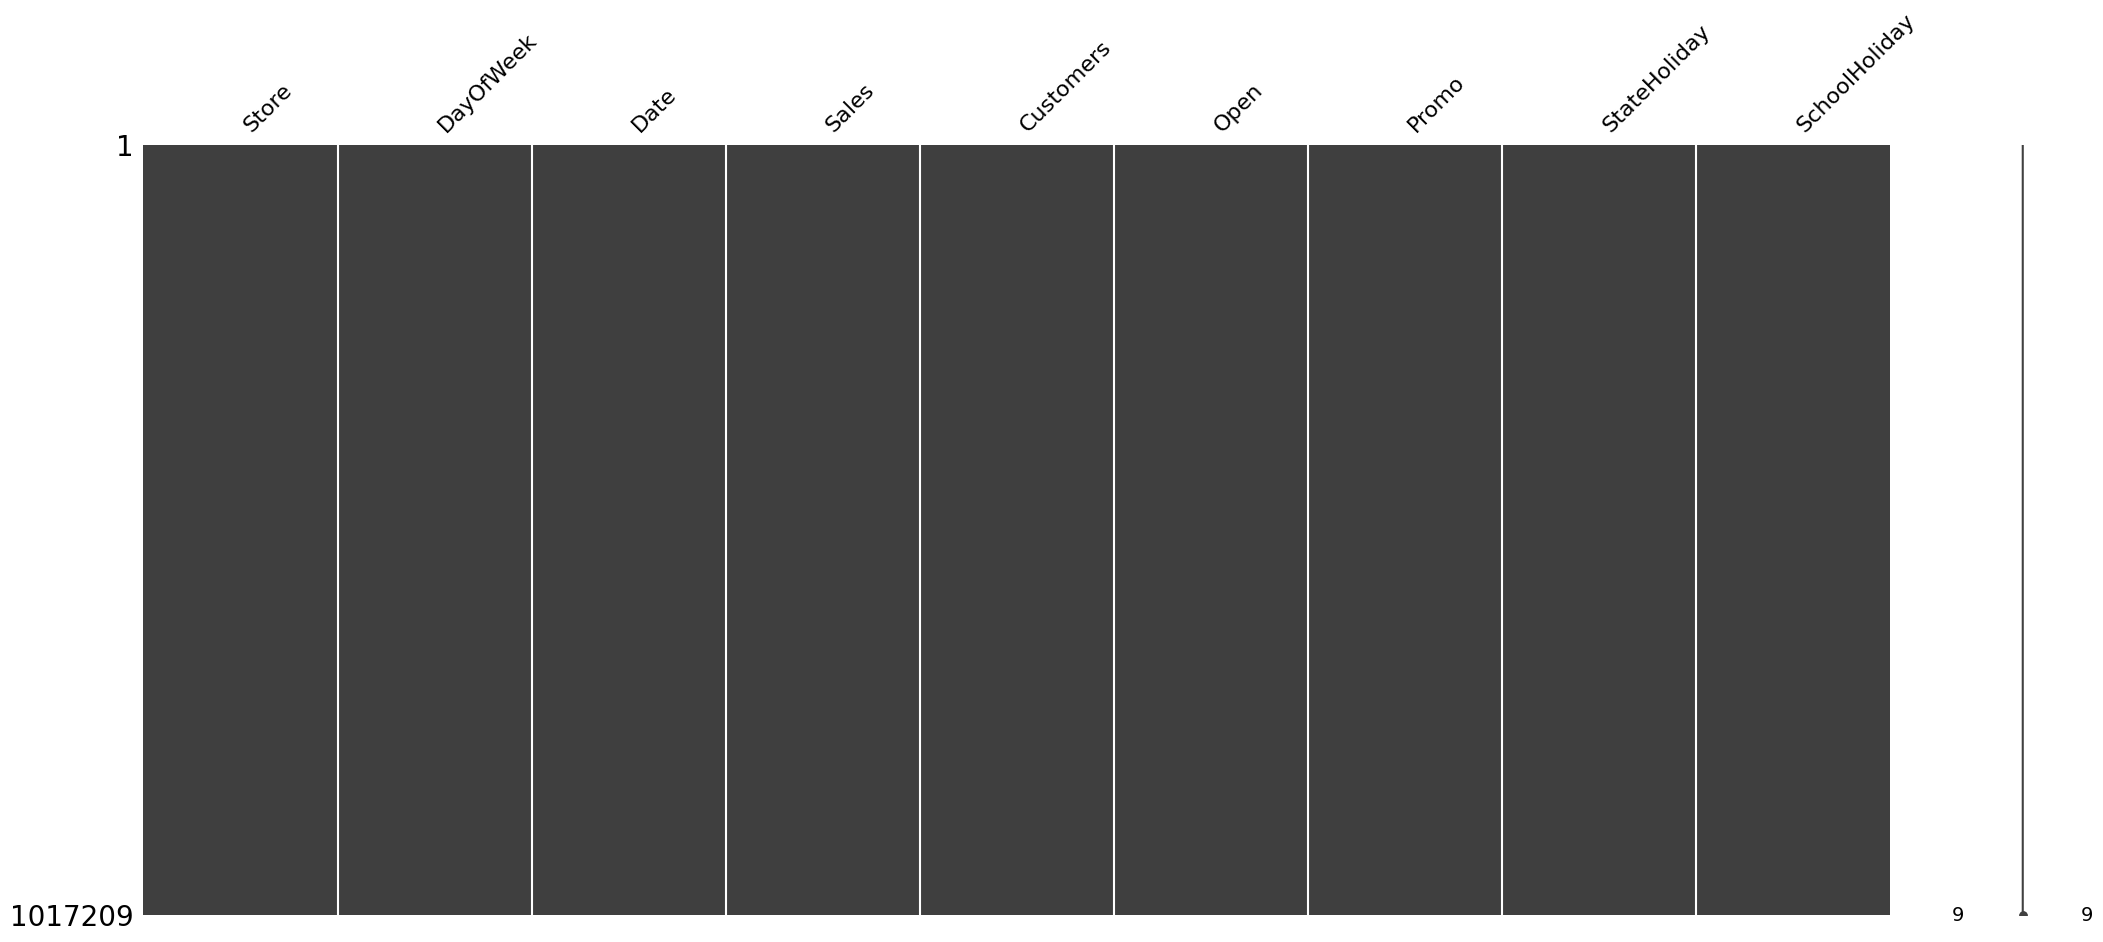

In [13]:
import missingno as msno
msno.matrix(df)

In [14]:
# Date range
print("Date range:", df['Date'].min(), "to", df['Date'].max())

Date range: 2013-01-01 to 2015-07-31


In [18]:
# Filter one store for simplicity
df_store = df[df['Store'] == 1].copy()

print("Date range:", df_store['Date'].min(), "to", df_store['Date'].max())

Date range: 2013-01-01 to 2015-07-31


In [19]:
# Check for missing dates in the Store 1 time series
expected_dates = pd.date_range(start=df_store['Date'].min(), end=df_store['Date'].max(), freq='D')
actual_dates = pd.to_datetime(df_store['Date'].unique())
missing_dates = expected_dates.difference(actual_dates)

print(f"Total expected dates: {len(expected_dates)}")
print(f"Actual dates present: {len(actual_dates)}")
print(f"Missing dates: {len(missing_dates)}")

if not missing_dates.empty:
    print("Missing days:\n", missing_dates)
else:
    print("No missing dates in the time series.")


Total expected dates: 942
Actual dates present: 942
Missing dates: 0
No missing dates in the time series.


In [20]:
# Convert Date to datetime
df_store['Date'] = pd.to_datetime(df_store['Date'])

# Create full daily time index
full_dates = pd.DataFrame({'ds': pd.date_range(df_store['Date'].min(), df_store['Date'].max())})

# Merge full calendar with actual data
df_store = df_store[['Date', 'Sales', 'Open']]
df_merged = full_dates.merge(df_store, left_on='ds', right_on='Date', how='left')

# Handle missing values
df_merged['Open'] = df_merged['Open'].fillna(0)  # Assume missing means closed
df_merged['y'] = df_merged['Sales'].fillna(0)    # Closed = 0 sales

# Final cleanup
df_merged.drop(columns=['Date', 'Sales'], inplace=True)
df_merged.rename(columns={'Open': 'open_flag'}, inplace=True)


In [21]:
df_merged.head()

,ds,open_flag,y
0,2013-01-01,0,0
1,2013-01-02,1,5530
2,2013-01-03,1,4327
3,2013-01-04,1,4486
4,2013-01-05,1,4997


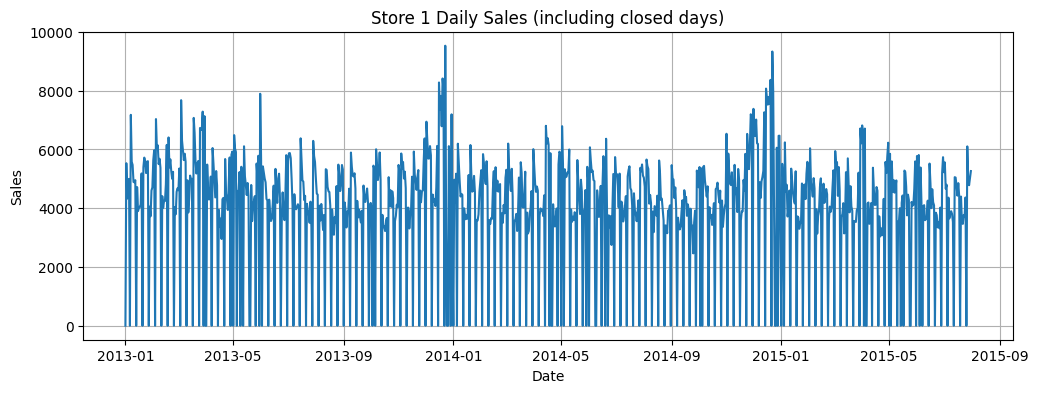

In [24]:
# 🧪 Step 8: Visualize the time series
plt.figure(figsize=(12,4))
plt.plot(df_merged['ds'], df_merged['y'])
plt.title("Store 1 Daily Sales (including closed days)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

In [25]:
# 🔀 Step 9: Train-Test Split
train = df_merged[df_merged['ds'] < '2015-07-01']
test = df_merged[df_merged['ds'] >= '2015-07-01']

In [26]:
# 🧠 Step 10: Train Prophet with 'open_flag' as regressor
model = Prophet()
model.add_regressor('open_flag')
model.fit(train)

22:29:51 - cmdstanpy - INFO - Chain [1] start processing
22:29:51 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
# ⏳ Step 11: Forecast
future = model.make_future_dataframe(periods=len(test))
# Reattach the regressor for the future dataframe
future = pd.merge(future, df_merged[['ds', 'open_flag']], on='ds', how='left')
forecast = model.predict(future)

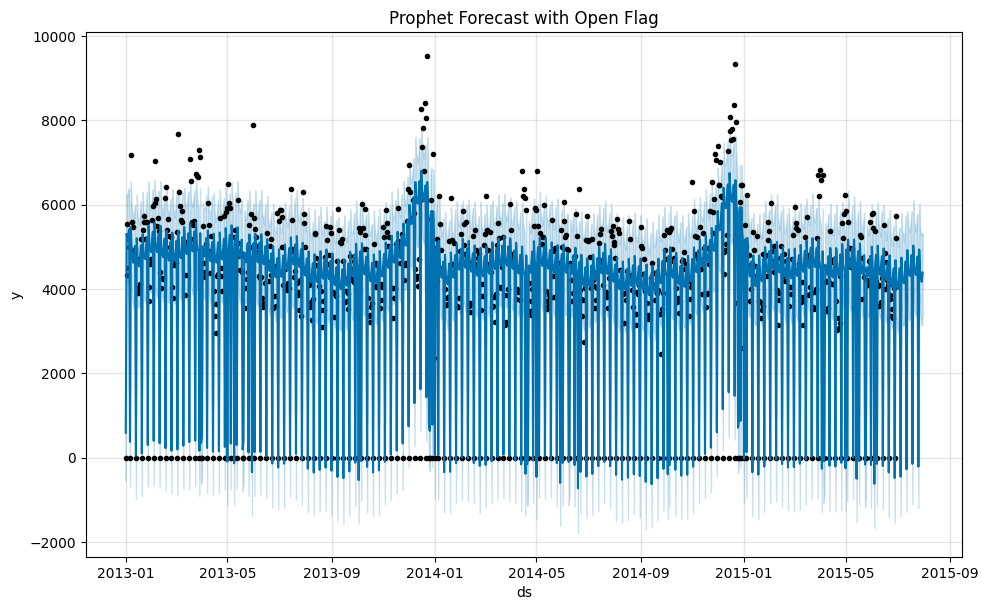

In [29]:
# 📊 Step 12: Plot Forecast
fig = model.plot(forecast)
plt.title("Prophet Forecast with Open Flag")
plt.show()

In [30]:
# 📈 Step 13: Evaluation
actuals = test[['ds', 'y']].copy()
predicted = forecast[['ds', 'yhat']].copy()
eval_df = pd.merge(actuals, predicted, on='ds')

mae = mean_absolute_error(eval_df['y'], eval_df['yhat'])
mape = mean_absolute_percentage_error(eval_df['y'], eval_df['yhat'])

print(f"📏 MAE: {mae:.2f}")
print(f"📏 MAPE: {mape:.2%}")

📏 MAE: 586.50
📏 MAPE: 15988482239919093760.00%


In [32]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Avoid division by zero
    nonzero_mask = y_true != 0
    if not np.any(nonzero_mask):
        return np.inf  # All actuals are zero — MAPE undefined
    
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100



In [33]:
mape = mean_absolute_percentage_error(eval_df['y'], eval_df['yhat'])
print(f"Filtered MAPE: {mape:.2f}%")


Filtered MAPE: 14.34%


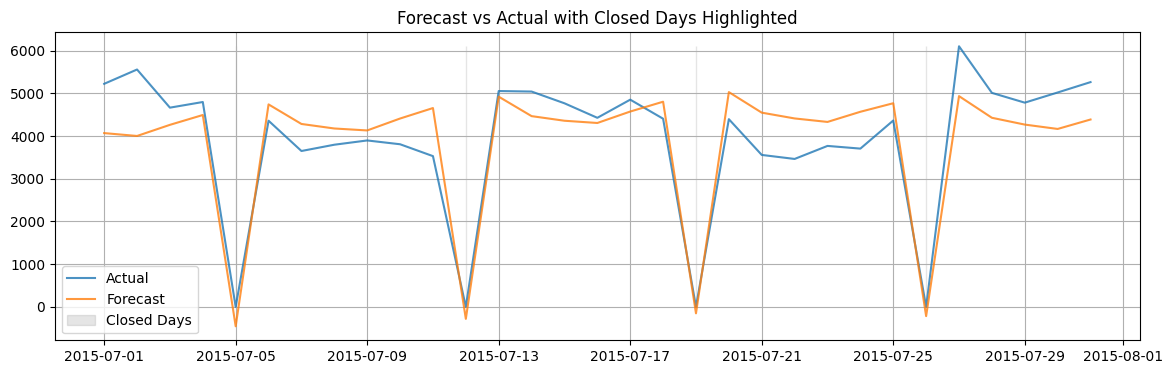

In [35]:
eval_df['error'] = eval_df['y'] - eval_df['yhat']
eval_df['abs_error'] = eval_df['error'].abs()

# Merge back open_flag
eval_df = eval_df.merge(df_merged[['ds', 'open_flag']], on='ds', how='left')

# Plot forecast vs actual
plt.figure(figsize=(14, 4))
plt.plot(eval_df['ds'], eval_df['y'], label='Actual', alpha=0.8)
plt.plot(eval_df['ds'], eval_df['yhat'], label='Forecast', alpha=0.8)
plt.fill_between(eval_df['ds'], 0, max(eval_df['y'].max(), eval_df['yhat'].max()), 
                 where=(eval_df['open_flag'] == 0), color='gray', alpha=0.2, label='Closed Days')
plt.title("Forecast vs Actual with Closed Days Highlighted")
plt.legend()
plt.grid(True)
plt.show()


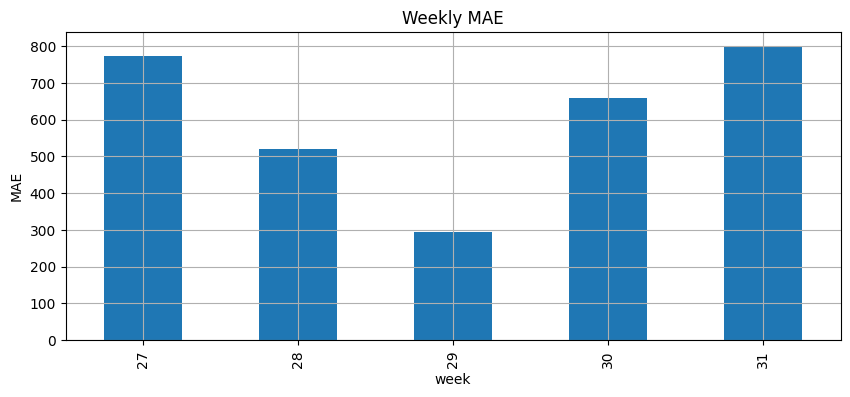

In [36]:
# Step 3: Segment Performance by Time Slice

# Prophet may perform well in some periods but fail in others.

eval_df['week'] = eval_df['ds'].dt.isocalendar().week
weekly_mae = eval_df.groupby('week')['abs_error'].mean()

plt.figure(figsize=(10, 4))
weekly_mae.plot(kind='bar')
plt.title("Weekly MAE")
plt.ylabel("MAE")
plt.grid(True)
plt.show()


### Adding more regressors

In [59]:
# Step 1: Start from original filtered store data
df_store = df[df['Store'] == 1].copy()
df_store['Date'] = pd.to_datetime(df_store['Date'])

# Step 2: Merge with full calendar
all_dates = pd.DataFrame({'ds': pd.date_range(df_store['Date'].min(), df_store['Date'].max())})

# Only needed columns + extra regressors
df_store = df_store[['Date', 'Sales', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday']]
df_store.rename(columns={'Date': 'ds'}, inplace=True)

# Merge full calendar
df_full = all_dates.merge(df_store, on='ds', how='left')

# Step 3: Handle missing values
df_full['Open'] = df_full['Open'].fillna(0)
df_full['y'] = df_full['Sales'].fillna(0)

In [60]:
# Regressors - fill with safe defaults
df_full['Promo'] = df_full['Promo'].fillna(0)
df_full['SchoolHoliday'] = df_full['SchoolHoliday'].fillna(0)
df_full['StateHoliday'] = df_full['StateHoliday'].fillna('0')  # originally string

# Step 4: Convert categorical `StateHoliday` to numeric flags
df_full = pd.get_dummies(df_full, columns=['StateHoliday'], prefix='holiday', drop_first=True)

# Step 5: Clean up column names
df_full.rename(columns={'Open': 'open_flag'}, inplace=True)
df_full.drop(columns=['Sales'], inplace=True)

## Add Regressors to Prophet

In [61]:
# 🔀 Step: Split into training and testing sets
train = df_full[df_full['ds'] < '2015-07-01'].copy()
test = df_full[df_full['ds'] >= '2015-07-01'].copy()

In [62]:
model = Prophet()

# Add the regressors used in train
model.add_regressor('open_flag')
model.add_regressor('Promo')
model.add_regressor('SchoolHoliday')
model.add_regressor('holiday_a')
model.add_regressor('holiday_b')
model.add_regressor('holiday_c')

# ✅ Now fit using the correct training DataFrame
model.fit(train)



22:59:24 - cmdstanpy - INFO - Chain [1] start processing
22:59:24 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
print(train.dtypes)

ds               datetime64[ns]
open_flag                 int64
Promo                     int64
SchoolHoliday             int64
y                         int64
holiday_0                  bool
holiday_a                  bool
holiday_b                  bool
holiday_c                  bool
dtype: object


In [54]:
# Ensure no duplicated column names
train = train.loc[:, ~train.columns.duplicated()]


In [55]:
print(train.columns[train.columns.duplicated()])  # Should return empty Index


Index([], dtype='object')


In [56]:
print(train.dtypes)

ds               datetime64[ns]
open_flag                 int64
Promo                     int64
SchoolHoliday             int64
y                         int64
holiday_0                  bool
holiday_a                  bool
holiday_b                  bool
holiday_c                  bool
dtype: object


In [57]:
model = Prophet()
model.add_regressor('open_flag')
model.add_regressor('Promo')
model.add_regressor('SchoolHoliday')
model.add_regressor('holiday_a')
model.add_regressor('holiday_b')
model.add_regressor('holiday_c')

model.fit(train)

22:55:48 - cmdstanpy - INFO - Chain [1] start processing
22:55:48 - cmdstanpy - INFO - Chain [1] done processing


In [64]:
# Generate future dates (same horizon as your test set)
future = model.make_future_dataframe(periods=len(test))

# Merge the full regressor set from df_full
# (Make sure df_full has all relevant columns: 'open_flag', 'Promo', etc.)
future = future.merge(df_full.drop(columns=['y']), on='ds', how='left')

# Ensure all regressors are numeric (safety net)
for col in future.columns:
    if col not in ['ds']:
        future[col] = pd.to_numeric(future[col], errors='coerce')

# Drop any rows with unexpected NaNs (just in case)
future = future.dropna()

In [65]:
forecast = model.predict(future)

In [66]:
# Merge actual test values
eval_df = test[['ds', 'y']].merge(forecast[['ds', 'yhat']], on='ds')

# Calculate error metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae = mean_absolute_error(eval_df['y'], eval_df['yhat'])
mape = mean_absolute_percentage_error(eval_df[eval_df['y'] != 0]['y'], eval_df[eval_df['y'] != 0]['yhat'])

print(f"📏 MAE: {mae:.2f}")
print(f"📏 MAPE (filtered): {mape:.2%}")


📏 MAE: 299.80
📏 MAPE (filtered): 6.54%


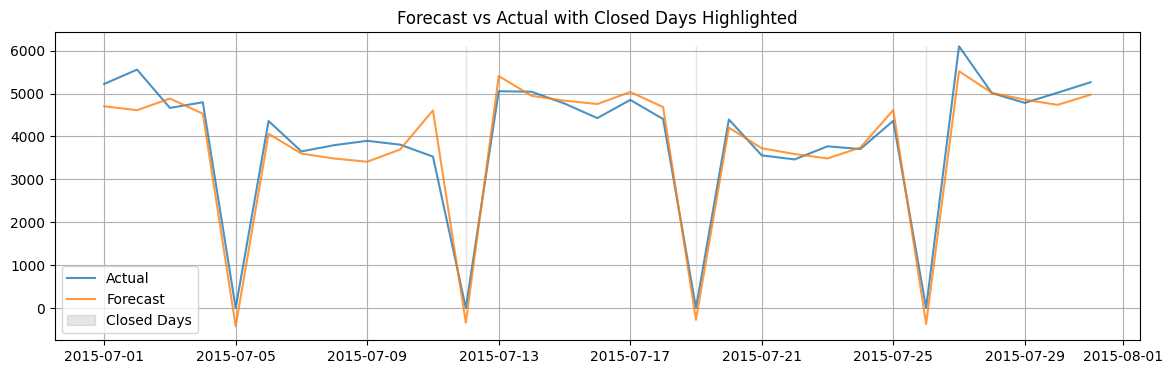

In [67]:
# Merge open_flag back in for context
eval_df = eval_df.merge(df_full[['ds', 'open_flag']], on='ds', how='left')

plt.figure(figsize=(14, 4))
plt.plot(eval_df['ds'], eval_df['y'], label='Actual', alpha=0.8)
plt.plot(eval_df['ds'], eval_df['yhat'], label='Forecast', alpha=0.8)
plt.fill_between(eval_df['ds'], 0, eval_df[['y', 'yhat']].max().max(),
                 where=(eval_df['open_flag'] == 0), color='gray', alpha=0.2, label='Closed Days')
plt.title("Forecast vs Actual with Closed Days Highlighted")
plt.legend()
plt.grid(True)
plt.show()


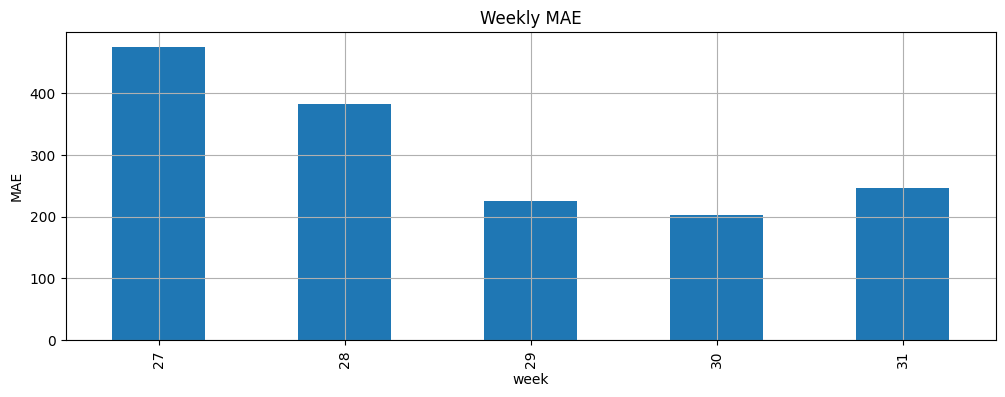

In [68]:
eval_df['week'] = eval_df['ds'].dt.isocalendar().week
eval_df['abs_error'] = (eval_df['y'] - eval_df['yhat']).abs()

weekly_mae = eval_df.groupby('week')['abs_error'].mean()

plt.figure(figsize=(12, 4))
weekly_mae.plot(kind='bar')
plt.title("Weekly MAE")
plt.ylabel("MAE")
plt.grid(True)
plt.show()


<Axes: title={'center': '📊 MAE by Day of Week'}, xlabel='dow'>

/Users/Waseem/Documents/GitHub/prophet-sales-forecasting/venv/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/Waseem/Documents/GitHub/prophet-sales-forecasting/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


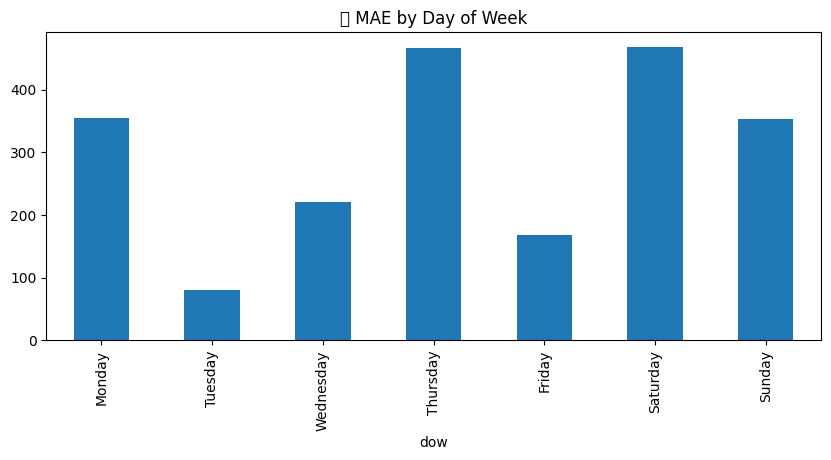

In [69]:
eval_df['dow'] = eval_df['ds'].dt.day_name()
dow_mae = eval_df.groupby('dow')['abs_error'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

dow_mae.plot(kind='bar', title='📊 MAE by Day of Week', figsize=(10,4))


In [71]:
# Error by open/closed
eval_df.groupby('open_flag')['abs_error'].mean()



open_flag
0    353.582759
1    291.830976
Name: abs_error, dtype: float64

In [72]:
# Error by promotion days
eval_df.groupby(df_full['Promo'])['abs_error'].mean()

Promo
0    304.453050
1    290.025334
Name: abs_error, dtype: float64

In [73]:
# Error by school holiday
eval_df.groupby(df_full['SchoolHoliday'])['abs_error'].mean()

SchoolHoliday
0    229.020181
1    428.487615
Name: abs_error, dtype: float64

In [75]:
df_full.head(20)

,ds,open_flag,Promo,SchoolHoliday,y,holiday_0,holiday_a,holiday_b,holiday_c
0,2013-01-01,0,0,1,0,False,True,False,False
1,2013-01-02,1,0,1,5530,True,False,False,False
2,2013-01-03,1,0,1,4327,True,False,False,False
3,2013-01-04,1,0,1,4486,True,False,False,False
4,2013-01-05,1,0,1,4997,True,False,False,False
5,2013-01-06,0,0,1,0,True,False,False,False
6,2013-01-07,1,1,1,7176,True,False,False,False
7,2013-01-08,1,1,1,5580,True,False,False,False
8,2013-01-09,1,1,1,5471,True,False,False,False
9,2013-01-10,1,1,1,4892,True,False,False,False


In [76]:
# Double check all regressors are there and numeric
print(future.dtypes)
print(future.isnull().sum())

ds               datetime64[ns]
open_flag                 int64
Promo                     int64
SchoolHoliday             int64
holiday_0                  bool
holiday_a                  bool
holiday_b                  bool
holiday_c                  bool
dtype: object
ds               0
open_flag        0
Promo            0
SchoolHoliday    0
holiday_0        0
holiday_a        0
holiday_b        0
holiday_c        0
dtype: int64


In [77]:
# Deep Dive into Forecast Errors Where Open == 0

# Pull out closed days
closed_days = eval_df[eval_df['open_flag'] == 0].copy()
closed_days['abs_error'] = (closed_days['y'] - closed_days['yhat']).abs()

# View average and sample rows
print("Closed-day MAE:", closed_days['abs_error'].mean())
print(closed_days[['ds', 'y', 'yhat', 'abs_error']].sort_values(by='abs_error', ascending=False).head())


Closed-day MAE: 353.58275857754165
           ds  y        yhat   abs_error
4  2015-07-05  0 -426.677064  426.677064
25 2015-07-26  0 -371.570009  371.570009
11 2015-07-12  0 -340.624593  340.624593
18 2015-07-19  0 -275.459368  275.459368


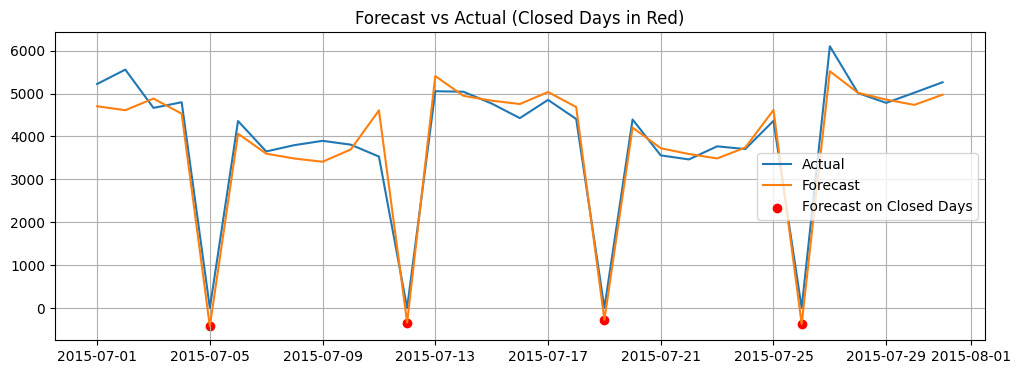

In [78]:
plt.figure(figsize=(12, 4))
plt.plot(eval_df['ds'], eval_df['y'], label='Actual')
plt.plot(eval_df['ds'], eval_df['yhat'], label='Forecast')
plt.scatter(closed_days['ds'], closed_days['yhat'], color='red', label='Forecast on Closed Days')
plt.title("Forecast vs Actual (Closed Days in Red)")
plt.legend()
plt.grid(True)
plt.show()


In [80]:
bad_rows = df[(df['Open'] == 0) & (df['Sales'] > 0)]
print(bad_rows)

Empty DataFrame
Columns: [Store, DayOfWeek, Date, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday]
Index: []


In [81]:
model = Prophet()

# Add the regressors used in train
model.add_regressor('open_flag', prior_scale=10)
model.add_regressor('Promo')
model.add_regressor('SchoolHoliday')
model.add_regressor('holiday_a')
model.add_regressor('holiday_b')
model.add_regressor('holiday_c')

# ✅ Now fit using the correct training DataFrame
model.fit(train)

23:17:23 - cmdstanpy - INFO - Chain [1] start processing
23:17:23 - cmdstanpy - INFO - Chain [1] done processing


In [82]:
# Generate future dates (same horizon as your test set)
future = model.make_future_dataframe(periods=len(test))

# Merge the full regressor set from df_full
# (Make sure df_full has all relevant columns: 'open_flag', 'Promo', etc.)
future = future.merge(df_full.drop(columns=['y']), on='ds', how='left')

# Ensure all regressors are numeric (safety net)
for col in future.columns:
    if col not in ['ds']:
        future[col] = pd.to_numeric(future[col], errors='coerce')

# Drop any rows with unexpected NaNs (just in case)
future = future.dropna()

In [83]:
forecast = model.predict(future)

In [84]:
# Merge actual test values
eval_df = test[['ds', 'y']].merge(forecast[['ds', 'yhat']], on='ds')

# Calculate error metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae = mean_absolute_error(eval_df['y'], eval_df['yhat'])
mape = mean_absolute_percentage_error(eval_df[eval_df['y'] != 0]['y'], eval_df[eval_df['y'] != 0]['yhat'])

print(f"📏 MAE: {mae:.2f}")
print(f"📏 MAPE (filtered): {mape:.2%}")

📏 MAE: 299.80
📏 MAPE (filtered): 6.54%


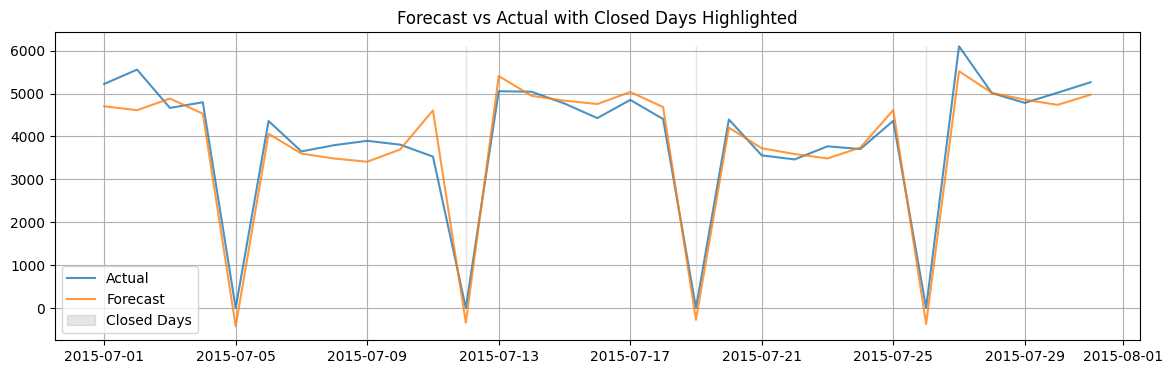

In [88]:
# Merge open_flag back in for context
eval_df = eval_df.merge(df_full[['ds', 'open_flag']], on='ds', how='left')

plt.figure(figsize=(14, 4))
plt.plot(eval_df['ds'], eval_df['y'], label='Actual', alpha=0.8)
plt.plot(eval_df['ds'], eval_df['yhat'], label='Forecast', alpha=0.8)
plt.fill_between(eval_df['ds'], 0, eval_df[['y', 'yhat']].max().max(),
                 where=(eval_df['open_flag'] == 0), color='gray', alpha=0.2, label='Closed Days')
plt.title("Forecast vs Actual with Closed Days Highlighted")
plt.legend()
plt.grid(True)
plt.show()

In [90]:
# Deep Dive into Forecast Errors Where Open == 0

# Pull out closed days
closed_days = eval_df[eval_df['open_flag'] == 0].copy()
closed_days['abs_error'] = (closed_days['y'] - closed_days['yhat']).abs()

# View average and sample rows
print("Closed-day MAE:", closed_days['abs_error'].mean())
print(closed_days[['ds', 'y', 'yhat', 'abs_error']].sort_values(by='abs_error', ascending=False).head())

Closed-day MAE: 353.58275857754165
           ds  y        yhat   abs_error
4  2015-07-05  0 -426.677064  426.677064
25 2015-07-26  0 -371.570009  371.570009
11 2015-07-12  0 -340.624593  340.624593
18 2015-07-19  0 -275.459368  275.459368
